# TM10007 Assignment

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.2 MB/s eta 0:00:00


## Import packages

In [2]:
import pandas as pd

from worcgist.load_data import load_data

## 1. Data loading

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [14]:
# Load data
data = load_data()

data['label'] = data['label'].map({'non-GIST': 0, 'GIST': 1})

y = data['label']
x = data.drop(columns=['label'])

# Calculate basic statistics
n_samples = len(y)
n_features = len(x.columns)

n_missing = data.isna().sum().sum()
n_zero = (data == 0).sum().sum()

n_non_gist = (y == 0).sum().sum()
n_gist = (y == 1).sum().sum()
# Print basic statistics
print(f'The number of samples: {n_samples}')
print(f'The number of features: {n_features}')
print(f'The number of datapoints: {n_samples * n_features}')
print(f"The number of missing values: {n_missing}")
print(f"The number of zero values: {n_zero}")
print(f"The percentage of zero values: {n_non_gist/(n_samples*n_features)*100} %")
print(f"The percentage of GIST tumors: {n_gist/n_samples*100} %")
print(f"The percentage of non-GIST tumors: {n_non_gist/n_samples*100} %")
#data.info()
#data.describe()
#data.duplicated()

The number of samples: 246
The number of features: 493
The number of datapoints: 121278
The number of missing values: 0
The number of zero values: 6848
The percentage of zero values: 0.0997707745840136 %
The percentage of GIST tumors: 50.81300813008131 %
The percentage of non-GIST tumors: 49.1869918699187 %


## 2. Pre-processing

### Remove constants

In [16]:
# Remove columns with constant values
constant_cols = x.columns[x.nunique() <= 1] # get columns with 1 unique value or all values NaN
x = x.drop(columns=constant_cols) # drop these columns

# Remove rows with constant values
constant_rows = x.index[x.nunique(axis=1) <= 1] # get rows with 1 unique value or all values NaN
x_clean = x.drop(index=constant_rows) # drop these columns

# Adjust y to match the remainng samples
y_clean = y.drop(index=constant_rows)

# Combine x_clean and y_clean to one DataFrame
data_constants_removed = pd.concat([x_clean, y_clean], axis=1)

# Get dimensions
dimensions_data_constants_removed = data_constants_removed.shape
n_samples_constants_removed, n_features_constants_removed = dimensions_data_constants_removed

# Change in dimension
samples_removed = n_samples - n_samples_constants_removed
features_removed = n_features - n_features_constants_removed

# Result
print(f'Number of removed samples: {samples_removed}')
print(f'Number of removed features: {features_removed}')
print(f'Dataset without constant values: {data_constants_removed.shape}')

data_constants_removed.head()

Number of removed samples: 0
Number of removed features: 12
Dataset without constant values: (246, 481)


,PREDICT_original_sf_compactness_avg_2.5D,PREDICT_original_sf_compactness_std_2.5D,PREDICT_original_sf_rad_dist_avg_2.5D,PREDICT_original_sf_rad_dist_std_2.5D,PREDICT_original_sf_roughness_avg_2.5D,PREDICT_original_sf_roughness_std_2.5D,PREDICT_original_sf_convexity_avg_2.5D,PREDICT_original_sf_convexity_std_2.5D,PREDICT_original_sf_cvar_avg_2.5D,PREDICT_original_sf_cvar_std_2.5D,...,PREDICT_original_phasef_phasesym_mean_WL3_N5,PREDICT_original_phasef_phasesym_median_WL3_N5,PREDICT_original_phasef_phasesym_std_WL3_N5,PREDICT_original_phasef_phasesym_skewness_WL3_N5,PREDICT_original_phasef_phasesym_kurtosis_WL3_N5,PREDICT_original_phasef_phasesym_range_WL3_N5,PREDICT_original_phasef_phasesym_energy_WL3_N5,PREDICT_original_phasef_phasesym_quartile_range_WL3_N5,PREDICT_original_phasef_phasesym_entropy_WL3_N5,label
ID,,,,,,,,,,,,,,,,,,,,,
GIST-001_0,0.797427,0.120594,80.192445,9.445741,7.102210,3.876595,0.927623,0.081385,0.015227,0.010465,...,0.005697,0.0,0.032461,7.353902,63.183181,0.123189,1591.133826,0.0,15.687095,1
GIST-002_0,0.896991,0.045854,35.323607,2.781343,5.339906,1.923100,0.975762,0.017550,0.009118,0.009385,...,0.009552,0.0,0.043431,6.452863,52.634005,0.172040,220.543010,0.0,12.664845,0
GIST-003_0,0.893238,0.051894,17.582541,1.864908,7.622507,1.039745,0.979608,0.017926,0.013258,0.010217,...,0.022104,0.0,0.068175,3.849719,16.277217,0.286710,62.150817,0.0,10.432943,1
GIST-004_0,0.914027,0.032078,21.951056,2.188093,4.757274,1.786309,0.981125,0.013734,0.011338,0.005147,...,0.010130,0.0,0.044148,5.725807,38.600415,0.182812,39.375540,0.0,10.194878,0
GIST-005_0,0.659747,0.266226,20.801224,4.025831,14.404912,7.695865,0.865275,0.171213,0.048078,0.047425,...,0.012287,0.0,0.043369,4.546357,23.831176,0.183349,24.192700,0.0,10.066832,0


In [ ]:
from scipy.stats import shapiro

def check_normal_distribution(df, alpha=0.05):
    """
    Check if each column in the given DataFrame follows a normal distribution.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing numerical data.
    alpha (float): The significance level for the Shapiro-Wilk test.

    Returns:
    pd.DataFrame: A DataFrame indicating whether each column in the input DataFrame follows a normal distribution.
    The DataFrame has one row and the same number of columns as the input DataFrame.
    """
    results = {}
    for col in df.columns:
        p = shapiro(df[col])[1]
        results[col] = p > alpha
    return pd.DataFrame([results])

results = check_normal_distribution(x)
#print(results)

In [ ]:
def replace_outliers(df, is_normal):
    """
    Replace outliers in the given DataFrame based on the distribution type of each column.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing numerical data.
    is_normal (pd.Series): A Series indicating whether each column in the DataFrame is normally distributed (True) or not (False).

    Returns:
    pd.DataFrame: The DataFrame with outliers replaced by the respective bounds.
    list: A list of all outlier values found.
    """
    threshold_nd = 1  # z-score threshold for normally distributed data
    threshold_nnd = 5  # IQR threshold for non-normally distributed data
    outliers_list = []  # Initialize an empty list to store outliers

    for column in df.columns:
        if is_normal[column]:
            # Use z-score for normally distributed columns
            mean = df[column].mean()
            std = df[column].std()
            lower_bound = mean - threshold_nd * std
            upper_bound = mean + threshold_nd * std
            outliers = (df[column] > upper_bound) | (df[column] < lower_bound)
            outliers_list.extend(df.loc[outliers, column].tolist())  # Append outliers to the list
            df.loc[df[column] > upper_bound, column] = upper_bound
            df.loc[df[column] < lower_bound, column] = lower_bound
        else:
            # Use IQR for non-normally distributed columns
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold_nnd * IQR
            upper_bound = Q3 + threshold_nnd * IQR
            outliers = (df[column] > upper_bound) | (df[column] < lower_bound)
            outliers_list.extend(df.loc[outliers, column].tolist())  # Append outliers to the list
            df.loc[df[column] > upper_bound, column] = upper_bound
            df.loc[df[column] < lower_bound, column] = lower_bound

    return df, outliers_list  # Return the modified DataFrame and the outliers list
df_no_outliers, outliers = replace_outliers(x, results.iloc[0])
print("Max of original data (first 5 columns):")
print(x.iloc[:, 10:20].describe().loc['max'])
print("Max of data without outliers (first 5 columns):")
print(df_no_outliers.iloc[:, 10:20].describe().loc['max'])
print("Number of outliers:", len(outliers))

<ipython-input-6-56050a730009>:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '87.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[column] > upper_bound, column] = upper_bound
<ipython-input-6-56050a730009>:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '75.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[column] > upper_bound, column] = upper_bound
<ipython-input-6-56050a730009>:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '28.18683538209948' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[column] > upper_bound, column] = upper_bound
<ipython-input-6-56050a730009>:26: FutureWar

Max of original data (first 5 columns):
PREDICT_original_sf_prax_avg_2.5D            0.816314
PREDICT_original_sf_prax_std_2.5D            0.169415
PREDICT_original_sf_evar_avg_2.5D            0.092291
PREDICT_original_sf_evar_std_2.5D            0.056980
PREDICT_original_sf_solidity_avg_2.5D        1.247305
PREDICT_original_sf_solidity_std_2.5D        0.230570
PREDICT_original_sf_area_avg_2.5D        21935.647267
PREDICT_original_sf_area_max_2.5D        36947.705399
PREDICT_original_sf_area_min_2.5D         1895.417736
PREDICT_original_sf_area_std_2.5D        10747.729719
Name: max, dtype: float64
Max of data without outliers (first 5 columns):
PREDICT_original_sf_prax_avg_2.5D            0.816314
PREDICT_original_sf_prax_std_2.5D            0.169415
PREDICT_original_sf_evar_avg_2.5D            0.092291
PREDICT_original_sf_evar_std_2.5D            0.056980
PREDICT_original_sf_solidity_avg_2.5D        1.247305
PREDICT_original_sf_solidity_std_2.5D        0.230570
PREDICT_original_sf_ar

## 3. Feature selection

In [5]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=50)
x_reduced_array = selector.fit_transform(x, y)
selected_feature_names = x.columns[selector.get_support()]
x_reduced = pd.DataFrame(x_reduced_array, columns=selected_feature_names)

## 4. Model training

1. Data Splitting:
   - The dataset is partitioned into an 80% training/validation set and a 20% test set using stratified sampling to preserve the class distribution.
   - The test set is reserved for final evaluation, ensuring an unbiased estimate of model performance on unseen data.

2. Pipeline Construction:
   - For each classifier (SVM, Random Forest, kNN, Logistic Regression, Linear Discriminant Analysis (LDA), and Quadratic Discriminant Analysis (QDA)), a pipeline is defined.
   - Each pipeline integrates a feature scaling step (using StandardScaler) to standardize the features, followed by the classifier.

3. Hyperparameter Tuning:
   - Hyperparameter grids are defined for models that require tuning (SVM, Random Forest, kNN, and Logistic Regression).
   - A grid search combined with stratified 5-fold cross-validation is employed to determine the optimal hyperparameters for each model.

4. Model Evaluation:
   - The best estimator from the grid search for each model is evaluated on the test set.
   - Evaluation metrics include accuracy, precision, recall, F1-score, and ROC-AUC (where applicable), providing a comprehensive assessment of performance.

5. Reproducibility:
   - The use of 'random_state=42' ensures that operations involving randomness (such as data splitting and model initialization) yield consistent results across multiple runs.





In [20]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# code mainly from:
# https://ryan-reilly.medium.com/gridsearch-pipelines-of-multiple-models-on-multiclass-classification-e9124b6ea2e3

# Splitting the data: 80% for training/validation, 20% for final testing.
X_train, X_test, y_train, y_test = train_test_split(
    x_reduced, y, test_size=0.2, stratify=y, random_state=42
)

# Define pipelines for each classifier.
pipeline_svm = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif, k=50)),
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, random_state=42))
])
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])
pipeline_dt = Pipeline([
    ('scl', StandardScaler()),
    ('DT',DecisionTreeClassifier(random_state=42))
])
pipeline_knn = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif, k=50)),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
pipeline_lr = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif, k=50)),
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])
pipeline_mlp = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif, k=50)),
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(max_iter=1000, early_stopping=True, random_state=42))
])

# Define hyperparameter grids for the models.
param_range = [1, 2, 3, 4, 5, 6]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [50,100,150]
learning_rates = [.1,.2,.3]

svm_param_grid = [{'svm__kernel': ['linear', 'rbf'],
                    'svm__C': param_range}]

rf_param_grid = [{'rf__min_samples_leaf': param_range,
                   'rf__max_depth': param_range,
                   'rf__min_samples_split': param_range[1:]}]

dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
                   'DT__min_samples_leaf': param_range,
                   'DT__max_depth': param_range,
                   'DT__min_samples_split': param_range[1:]}]

knn_param_grid = [{'knn__n_neighbors': param_range,
                   'knn__weights': ['uniform', 'distance'],
                   'knn__metric': ['euclidean', 'manhattan']}]

lr_param_grid = [{'lr__penalty': ['l1', 'l2'],
                   'lr__C': param_range_fl,
                   'lr__solver': ['liblinear']}]

mlp_param_grid = [{
    'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'mlp__activation': ['tanh', 'relu'],
    'mlp__solver': ['adam'],
    'mlp__alpha': [0.0001, 0.001],
    'mlp__learning_rate': ['constant','adaptive']
}]

# Setup grid search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm_grid_search = GridSearchCV(estimator=pipeline_svm,
        param_grid=svm_param_grid,
        scoring='accuracy',
        cv=cv)
rf_grid_search = GridSearchCV(estimator=pipeline_rf,
        param_grid=rf_param_grid,
        scoring='accuracy',
        cv=cv)
dt_grid_search = GridSearchCV(estimator=pipeline_dt,
        param_grid=dt_param_grid,
        scoring='accuracy',
        cv=cv)
knn_grid_search = GridSearchCV(estimator=pipeline_knn,
        param_grid=knn_param_grid,
        scoring='accuracy',
        cv=cv)
lr_grid_search = GridSearchCV(estimator=pipeline_lr,
        param_grid=lr_param_grid,
        scoring='accuracy',
        cv=cv)
mlp_grid_search = GridSearchCV(estimator=pipeline_mlp,
        param_grid=mlp_param_grid,
        scoring='accuracy',
        cv=cv)
grids = [svm_grid_search, rf_grid_search, dt_grid_search, knn_grid_search, lr_grid_search, mlp_grid_search]

for pipe in grids:
    pipe.fit(X_train,y_train)


## 5. Model evaluation

In [21]:
grid_dict = {0: 'Support Vector Machine', 1: 'Random Forrest', 2: 'Decision Tree',
             3: 'K Nearest Neighbor', 4: 'Logistic Regression', 5: 'multi-layer perceptron'
             }
results_list = []

for i, model in enumerate(grids):
    model_name = grid_dict[i]
    accuracy = model.score(X_test, y_test)
    best_params = model.best_params_

    results_list.append({
        'Model': model_name,
        'Test Accuracy': accuracy,
        'Best Hyperparameters': best_params
    })

results_df = pd.DataFrame(results_list)
results_df.sort_values(by='Test Accuracy', ascending=False, inplace=True)

from IPython.display import display

pd.set_option('display.max_colwidth', 200)
display(results_df)

,Model,Test Accuracy,Best Hyperparameters
1,Random Forrest,0.62,"{'rf__max_depth': 1, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2}"
2,Decision Tree,0.62,"{'DT__criterion': 'gini', 'DT__max_depth': 5, 'DT__min_samples_leaf': 4, 'DT__min_samples_split': 2}"
0,Support Vector Machine,0.60,"{'svm__C': 1, 'svm__kernel': 'rbf'}"
4,Logistic Regression,0.60,"{'lr__C': 0.1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}"
3,K Nearest Neighbor,0.52,"{'knn__metric': 'manhattan', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}"
5,multi-layer perceptron,0.52,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'constant', 'mlp__solver': 'adam'}"


In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

best_model = grids[0].best_estimator_
y_pred = best_model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Precision: 0.782608695652174
Recall: 0.72
F1-score: 0.75


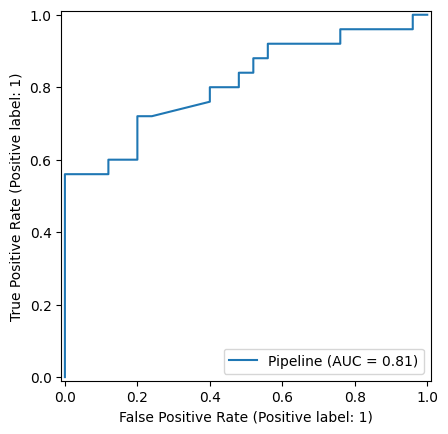

In [10]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

y_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)

RocCurveDisplay.from_estimator(best_model, X_test, y_test)

Text(0.5, 1.0, 'Learning Curve')

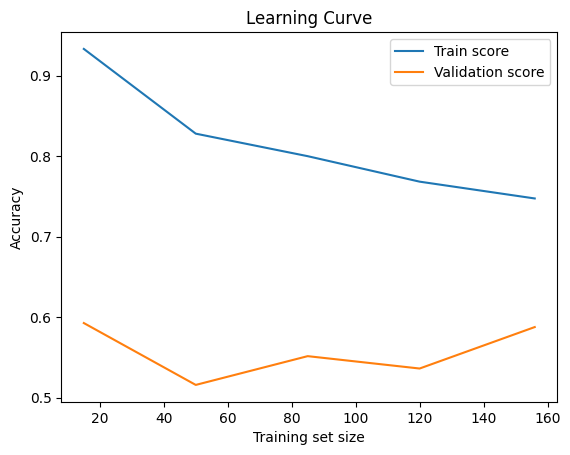

In [11]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, cv=cv, scoring='accuracy')

plt.plot(train_sizes, train_scores.mean(axis=1), label='Train score')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation score')
plt.legend()
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')